In [2]:
from teleconnections.plots import hovmoller_plot
from teleconnections import mjo_hovmoller
from aqua import Reader

In [9]:
%reload_ext autoreload
%autoreload 2

MJO is a teleconnection that require daily aggregated data.
We specify the teleconnection name and the model/exp/source to analyze.

In [3]:
telecname = 'MJO'

model = 'IFS'
exp = 'tco1279-orca025-cycle3'
source = '2D_1h_0.25deg'

The Reader class is user to retrieve the data, with standard resolution `r025` and the `daily` frequency.

In [4]:
reader = Reader(model=model,exp=exp,source=source, regrid='r025', freq='daily')
data = reader.retrieve()

2023-11-06 16:15:17 :: eccodes :: WARNING  -> ShortName tprate have multiple grib codes associated: ['260048', '172228']
2023-11-06 16:15:17 :: eccodes :: WARNING  -> AQUA will take the first so that tprate -> 260048, please set up a correct fix if this does not look right
2023-11-06 16:15:17 :: eccodes :: WARNING  -> AQUA will take the first so that tprate -> 260048, please set up a correct fix if this does not look right


In order to plot the data we subselect a time slice of data, then we use the `Reader` methods to obtain the correctly formatted data for the plot

In [5]:
sel = {'time': slice('2021-01-01','2021-06-30')}

data_sel = data.sel(**sel)
data_sel = reader.timmean(data_sel)
data_sel = reader.regrid(data_sel)

Finally the data are smoothed with a 5 days rolling window, selecting the correct variable and ready to be plotted.

In [7]:
data_smooth = mjo_hovmoller(data_sel, telecname=telecname, loglevel='INFO')

2023-11-06 16:17:36 :: MJO :: INFO     -> No namelist provided. Trying to load default namelist.
2023-11-06 16:17:36 :: MJO :: INFO     -> Subselecting var mtntrf


To plot we use the `hovmoller_plot` function from the module

2023-11-06 16:24:05 :: Hovmoller :: INFO     -> Averaging over dimension: lat
2023-11-06 16:24:05 :: Hovmoller :: DEBUG    -> Not centering colorbar around zero
2023-11-06 16:24:52 :: Hovmoller :: DEBUG    -> vmin: -54.19671086217604, vmax: 81.99389836478471


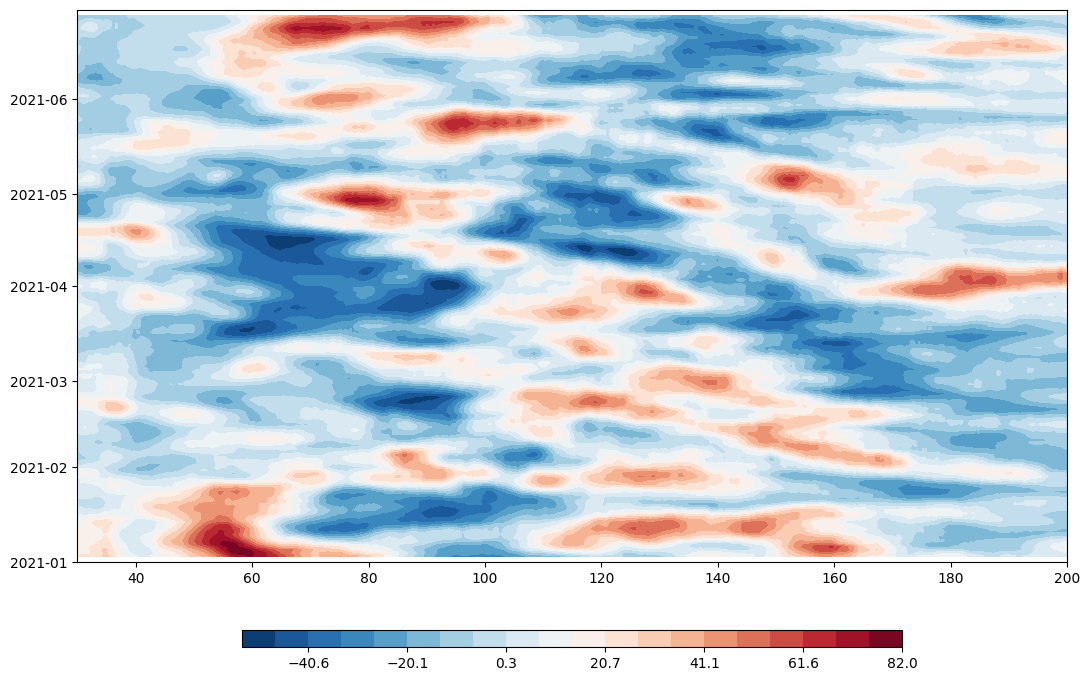

In [11]:
hovmoller_plot(data_smooth, dim='lat', invert_axis=True, nlevels=21, loglevel='DEBUG')

From the sate Dataset we can smooth and plot another variable, overwriting the default variable from the MJO namelist.

In [56]:
data_smooth_wind = mjo_hovmoller(data=data_sel, var='10u', telecname=telecname)

2023-11-06 15:34:20 :: Hovmoller :: DEBUG    -> Plotting Hovmoller diagram
2023-11-06 15:34:20 :: Hovmoller :: INFO     -> Averaging over dimension: lat
2023-11-06 15:34:20 :: Hovmoller :: DEBUG    -> Centering colorbar around zero
2023-11-06 15:34:20 :: Hovmoller :: WARNING  -> Exploring data to find absmax, may take a while


2023-11-06 15:34:56 :: Hovmoller :: DEBUG    -> vmin: -6.566019993464506, vmax: 6.566019993464506


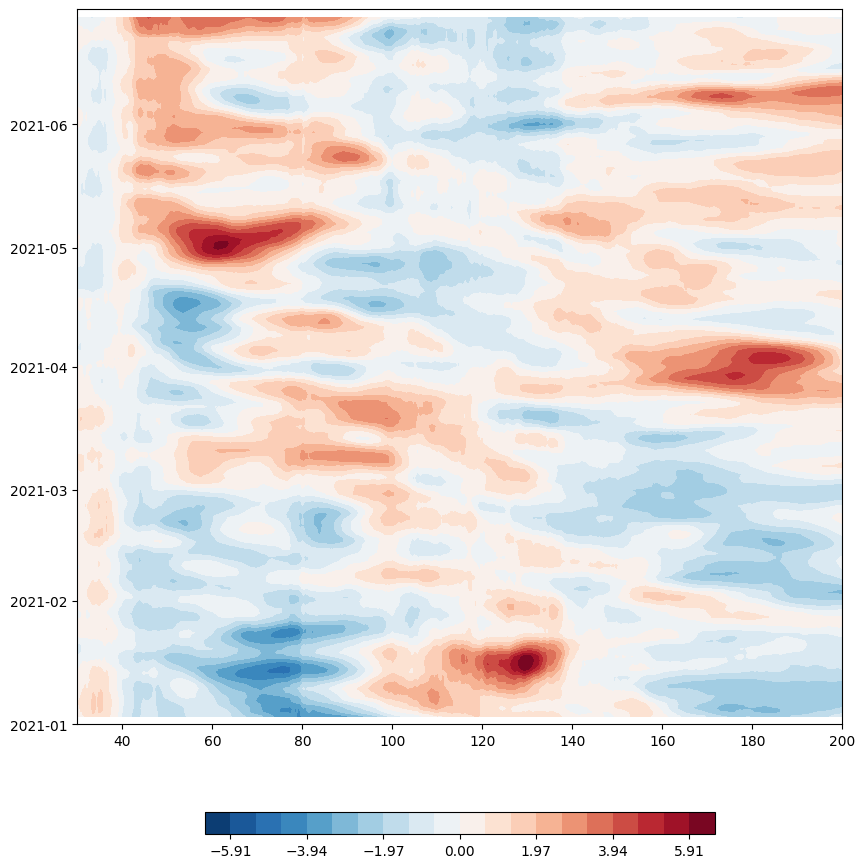

In [57]:
hovmoller_plot(data_smooth_wind, dim='lat', invert_axis=True, nlevels=21, loglevel='DEBUG', center=True)